In [1]:
import numpy as np
import qutip as qt
import scipy.stats as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import random
from ipynb.fs.full.myfunctions import *

In [155]:
def sample_ginibre_ensemble(n, p, dim_n, dim_k=None):
    # draw n states from the ginibre distribution (unbiased)
    if dim_k is None: dim_kk = dim_n
    else: dim_kk = dim_k
    x_0 = np.zeros((n, dim_n**2))
    w_0 = np.ones(n)/n
    for i in range(n):
        dm = rand_dm_ginibre(dim_n, dim_kk)
        x_0[i] = dm_to_bvector(dm, p, dim_n) # calculate pauli representation
    return x_0, w_0

def measurement(rho, c, dim):
    # create a measurement outcome of the state rho (in pauli representation) when measured in basis c
    prob = dim * np.sum(rho * c)
    if random.uniform(0, 1) < prob: res = 1
    else: res = 0
    return res

def experiment(rho, c, rep, dim):
    # measure rho pauli basises specified in c, repear ech measurement rep times, return # of measuered 1s
    c_rep = np.tile(c, [1, rep]).reshape((len(c) * rep, dim**2)) # repeated measurements
    d_rep = np.array([measurement(rho, c_i, dim) for c_i in c_rep]) # generate random measurements on rho     
    return np.sum(np.reshape(d_rep, (len(c), meas_rep)), axis= 1) # sum over measurement repetitions

def haarrand_measurement_basis(n, p, dim):
    # create n haar random bloch vectors of unit length
    c = np.zeros((n, dim**2))
    for i in range(n):
        dm = qt.ket2dm(qt.rand_ket_haar(dim))
        c[i] = dm_to_bvector(dm, p, dim)
    return c
    
def likelihood(x, d, c, rep, dim):
    # calculate likelihood of measurement outcome d given that the state is x
    p = [dim * np.sum(x_i * c) for x_i in x]
    return np.array([sp.binom.pmf(d, rep, p[i]) for i in range(len(x))])

def update_weights(x, w, d, c, rep, dim):
    # update weights according to likelihood and normalize, check whether resampling is required
    w_new = w * likelihood(x, d, c, rep, dim)
    w_new = np.divide(w_new, np.sum(w_new))
    return w_new

def pointestimate(x, w):
    # return point estimate of rho
    return np.average(x, axis=0, weights= w)

def fidelity(a, b, p):
    # compute fidelity from density matrices in Pauli representation
    return qt.metrics.fidelity(bvector_to_dm(a, p), bvector_to_dm(b, p))**2

In [72]:
n_q = 2 # number of Qubits - fixed in this implementation
dim = 2**n_q # Dimension of Hilbert space
p = create_pauli_basis(n_q) # create Pauli basis

# ideal state
rho = sample_ginibre_ensemble(1, p, dim, dim)[0][0]

# Experiment in Pauli basis
n_meas = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] # number of measurements
meas_rep = 8 # number of repetitions of measurement

# Sampling
n = 1000 # number of sampling points

# repetitions
rep = 20

In [ ]:
## Likelihood K == N == 4
## n+1 to calculate later on the cases for which rho is part of ensemble and not

lh = np.zeros((rep, n_meas[-1], n+1))
xx = np.zeros((rep, n+1, dim**2))
ww = np.zeros((rep, n+1))

for i in range(rep):
    x_0, w_0 = sample_ginibre_ensemble(n+1, p, dim, dim)
    xx[i] = x_0
    ww[i] = w_0
    rho = x_0[0]
    c_meas = haarrand_measurement_basis(n_meas[-1], p, dim)
    d_meas = experiment(rho, c_meas, meas_rep, dim)    
    for j in range(len(c_meas)):
        lh[i][j] = likelihood(x_0, d_meas[j], c_meas[j], meas_rep, dim)

np.savetxt('lh.txt', np.reshape(lh, (-1)))
np.savetxt('xx.txt', np.reshape(xx, (-1)))
np.savetxt('ww.txt', np.reshape(ww, (-1)))

In [175]:
## FIDELITY PLOT K = N

n_q = 2 # number of Qubits - fixed in this implementation
dim = 2**n_q # Dimension of Hilbert space
p = create_pauli_basis(n_q) # create Pauli basis

# ideal state
rho = sample_ginibre_ensemble(1, p, dim, dim)[0][0]

# Experiment in Pauli basis
n_meas = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] # number of measurements
meas_rep = 8 # number of repetitions of measurement

# Sampling
n = 10000 # number of sampling points

# repetitions
rep = 20

In [99]:
## Likelihood K == N - 1 == 3

lh = np.zeros((rep, n_meas[-1], n))
xx = np.zeros((rep, n, dim**2))
ww = np.zeros((rep, n))
rr = np.zeros((rep, dim**2))

for i in range(rep):
    x_0, w_0 = sample_ginibre_ensemble(n, p, dim, dim-1)
    xx[i] = x_0
    ww[i] = w_0
    rho = sample_ginibre_ensemble(n, p, dim, dim)[0][0]
    rr[i] = rho
    c_meas = haarrand_measurement_basis(n_meas[-1], p, dim)
    d_meas = experiment(rho, c_meas, meas_rep, dim)    
    for j in range(len(c_meas)):
        lh[i][j] = likelihood(x_0, d_meas[j], c_meas[j], meas_rep, dim)
    if (i+1)%5 == 0: print(i+1)

np.savetxt('lh3.txt', np.reshape(lh, (-1)))
np.savetxt('xx3.txt', np.reshape(xx, (-1)))
np.savetxt('ww3.txt', np.reshape(ww, (-1)))
np.savetxt('rr3.txt', np.reshape(rr, (-1)))

5
10
15
20


In [100]:
## Likelihood K == N - 3 == 1 -> Pure States

lh = np.zeros((rep, n_meas[-1], n))
xx = np.zeros((rep, n, dim**2))
ww = np.zeros((rep, n))
rr = np.zeros((rep, dim**2))

for i in range(rep):
    x_0, w_0 = sample_ginibre_ensemble(n, p, dim, dim-3)
    xx[i] = x_0
    ww[i] = w_0
    rho = sample_ginibre_ensemble(n, p, dim, dim)[0][0]
    rr[i] = rho
    c_meas = haarrand_measurement_basis(n_meas[-1], p, dim)
    d_meas = experiment(rho, c_meas, meas_rep, dim)    
    for j in range(len(c_meas)):
        lh[i][j] = likelihood(x_0, d_meas[j], c_meas[j], meas_rep, dim)
    if (i+1)%5 == 0: print(i+1)

np.savetxt('lh1.txt', np.reshape(lh, (-1)))
np.savetxt('xx1.txt', np.reshape(xx, (-1)))
np.savetxt('ww1.txt', np.reshape(ww, (-1)))
np.savetxt('rr1.txt', np.reshape(rr, (-1)))

5
10
15
20


In [176]:
## Likelihood K == N - 2 == 2

lh = np.zeros((rep, n_meas[-1], n))
xx = np.zeros((rep, n, dim**2))
ww = np.zeros((rep, n))
rr = np.zeros((rep, dim**2))

for i in range(rep):
    x_0, w_0 = sample_ginibre_ensemble(n, p, dim, 2)
    xx[i] = x_0
    ww[i] = w_0
    rho = sample_ginibre_ensemble(n, p, dim, dim)[0][0]
    rr[i] = rho
    c_meas = haarrand_measurement_basis(n_meas[-1], p, dim)
    d_meas = experiment(rho, c_meas, meas_rep, dim)    
    for j in range(len(c_meas)):
        lh[i][j] = likelihood(x_0, d_meas[j], c_meas[j], meas_rep, dim)
    if (i+1)%5 == 0: print(i+1)

np.savetxt('lh2.txt', np.reshape(lh, (-1)))
np.savetxt('xx2.txt', np.reshape(xx, (-1)))
np.savetxt('ww2.txt', np.reshape(ww, (-1)))
np.savetxt('rr2.txt', np.reshape(rr, (-1)))

5
10
15
20


In [178]:
# Load Data

xx1 = np.reshape(np.loadtxt('xx1.txt'), (rep, n, dim**2))
ww1 = np.reshape(np.loadtxt('ww1.txt'), (rep, n))
rr1 = np.reshape(np.loadtxt('rr1.txt'), (rep, dim**2))
lh1 = np.reshape(np.loadtxt('lh1.txt'), (rep, n_meas[-1], n))
print('1')

xx2 = np.reshape(np.loadtxt('xx2.txt'), (rep, n, dim**2))
ww2 = np.reshape(np.loadtxt('ww2.txt'), (rep, n))
rr2 = np.reshape(np.loadtxt('rr2.txt'), (rep, dim**2))
lh2 = np.reshape(np.loadtxt('lh2.txt'), (rep, n_meas[-1], n))
print('1')

lh3 = np.reshape(np.loadtxt('lh3.txt'), (rep, n_meas[-1], n))
xx3 = np.reshape(np.loadtxt('xx3.txt'), (rep, n, dim**2))
ww3 = np.reshape(np.loadtxt('ww3.txt'), (rep, n))
rr3 = np.reshape(np.loadtxt('rr3.txt'), (rep, dim**2))
print('2')

lh4 = np.reshape(np.loadtxt('lh.txt'), (rep, n_meas[-1], n+1))
xx4 = np.reshape(np.loadtxt('xx.txt'), (rep, n+1, dim**2))
ww4 = np.reshape(np.loadtxt('ww.txt'), (rep, n+1))
print('3')

lh4_1 = lh4[:, :, 1:]
xx4_1 = xx4[:, 1:]
ww4_1 = ww4[:, 1:]
rr4_1 = xx4[:, 0]
lh4_2 = lh4[:, :, :-1]
xx4_2 = xx4[:, :-1]
ww4_2 = ww4[:, :-1]
rr4_2 = xx4[:, 0]

lh = [lh1, lh2, lh3, lh4_1, lh4_2]
xx = [xx1, xx2, xx3, xx4_1, xx4_2]
ww = [ww1, ww2, ww3, ww4_1, ww4_2]
rr = [rr1, rr2, rr3, rr4_1, rr4_2]

3


In [ ]:
# Estimation

fid = np.zeros((5, len(n_meas)))
n_eff = np.zeros((5, len(n_meas)))

for k in range(5):
    for idj, j in enumerate(n_meas): # loop over number of measurements per estimate
        fid_temp = np.zeros((rep, n_meas[-1] // j))
        n_eff_temp = np.zeros((rep, n_meas[-1] // j))
        for i in range(rep): # loop over the independent repetitions (new ensemble, new measurement basis)
            for l in range(n_meas[-1] // j): # repeat estimate if j != n_meas[-1]
                w1=ww[k][i]
                for m in range(j): # loop over measurements
                    w1 = w1 * lh[k][i, m + l]
                    w1 = np.divide(w1, np.sum(w1))
                n_eff_temp[i][l] = 1 / np.sum(w1**2)
                fid_temp[i][l] = fidelity(rr[k][i], pointestimate(xx[k][i], w1), p)
        fid[k, idj] = np.mean(fid_temp, axis=(0, 1))
        n_eff[k, idj] = np.mean(n_eff_temp, axis=(0, 1))

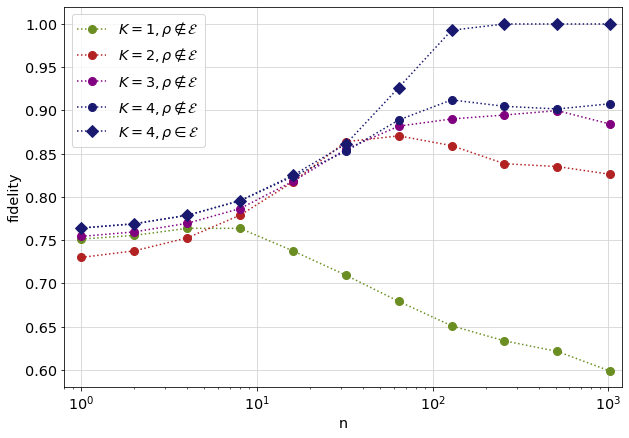

In [193]:
# Plot fidelities

fig = plt.figure(figsize=(10, 7))
m_s = 8
plt.plot(n_meas, fid[0], label=r'$K = 1, \rho \, \notin \, \mathcal{E}$', ls=':', marker='o', ms= m_s, c='olivedrab')
plt.plot(n_meas, fid[1], label=r'$K = 2, \rho \, \notin \, \mathcal{E}$', ls=':', marker='o', ms= m_s, c='firebrick')
plt.plot(n_meas, fid[2], label=r'$K = 3, \rho \, \notin \, \mathcal{E}$', ls=':', marker='o', ms= m_s, c='purple')
plt.plot(n_meas, fid[3], label=r'$K = 4, \rho \, \notin \, \mathcal{E}$', ls=':', marker='o', ms= m_s,c='midnightblue')
plt.plot(n_meas, fid[4], label=r'$K = 4, \rho \in \mathcal{E}$', ls=':', marker='D', ms= m_s, c='midnightblue')
plt.xscale('log', base=10)
plt.ylim(0.58, 1.02)
plt.xlim(0.8, 1200)
plt.xlabel('n', fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.ylabel('fidelity', fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.grid(c='lightgray')
plt.legend(fontsize='x-large')
plt.show()

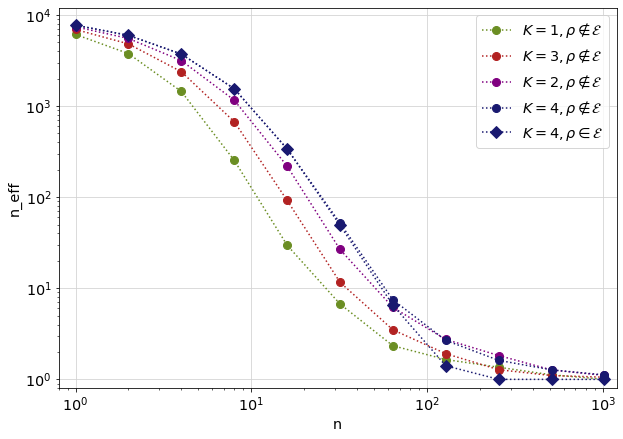

In [192]:
# Plot n_eff

fig = plt.figure(figsize=(10, 7))
m_s = 8
plt.plot(n_meas, n_eff[0], label=r'$K = 1, \rho \, \notin \, \mathcal{E}$', ls=':', marker='o', ms = m_s, c='olivedrab')
plt.plot(n_meas, n_eff[1], label=r'$K = 3, \rho \, \notin \, \mathcal{E}$', ls=':', marker='o', ms = m_s, c='firebrick')
plt.plot(n_meas, n_eff[2], label=r'$K = 2, \rho \, \notin \, \mathcal{E}$', ls=':', marker='o', ms = m_s, c='purple')
plt.plot(n_meas, n_eff[3], label=r'$K = 4, \rho \, \notin \, \mathcal{E}$', ls=':', marker='o', ms = m_s, c='midnightblue')
plt.plot(n_meas, n_eff[4], label=r'$K = 4, \rho \in \mathcal{E}$', ls=':', marker='D', ms = m_s, c='midnightblue')
plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.ylim(0.8, 12000)
plt.xlim(0.8, 1200)
plt.xlabel('n', fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.ylabel('n_eff', fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.grid(c='lightgray')
plt.legend(fontsize='x-large')
plt.show()